## Import libraries

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import string
import pickle
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE

import gensim
import gensim.models.word2vec as w2v
import multiprocessing

## Read in the files

In [ ]:
df = pd.read_csv("BTS_lyrics.csv",header=0)
df.head(5)

## Word Clouds

### One song

In [ ]:
idx = 10
# which song
title = df.Title[idx]
# lyrics
lyrics = df.Lyrics[idx]
print(title,lyrics)

In [ ]:
# Create a wordcloud image
wordcloud = WordCloud(max_words=100, background_color="white").generate(lyrics)
# Display the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### All songs

In [ ]:
text = " ".join(l for l in df.Lyrics)
print("There are {} words in the combination of all lyrics.".format(len(text)))

In [ ]:
# Create a wordcloud image
stopwords = ['even']
wordcloud = WordCloud(stopwords=stopwords,max_words=400, background_color="white").generate(text)
# Display the image
plt.figure(figsize = (15, 15), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Feature Extraction

### TF-IDF

In [ ]:
# list of lyrics of all the songs
lyrics = df.Lyrics

In [ ]:
# Initializes the vectorizer
tfidf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word', max_features=None)
# Fit and transform the lyrics
X_fitted = tfidf.fit(lyrics)
X_tf = X_fitted.transform(lyrics)

## Topic Modeling
### NMF

In [ ]:
# Initiazlies everything
no_topics = 9
nmf = NMF(n_components=no_topics, alpha=.1, l1_ratio=.5).fit(X_tf)
nmf_W = nmf.transform(X_tf)
nmf_H = nmf.components_
vocab = tfidf.get_feature_names()
no_top_words = 10
no_top_documents = 2

In [ ]:
# Helper function to display all the topics as the words associated with each of them
def display_topics(H, W, feature_names, documents, no_top_words):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
# Display the topics
display_topics(nmf_H, nmf_W, vocab, lyrics, no_top_words)

Now we need to put the correct documents (songs) into their corresponding topics

In [ ]:
doc_topics = pd.DataFrame()
for topic_idx, topic in enumerate(nmf_H):
    doc_indices = np.argsort( nmf_W[:,topic_idx] )[::-1][0:15]
    doc_topics[topic_idx] = doc_indices

topics = []
for i in range(0,9):
    topic = [1 if j in list(doc_topics[i]) else 0 for j in range(0,len(df))]
    df['Topic_'+str(i)] = topic

Now we'll aggregate across 'Album' and count how many songs in each album are of a certain topic

In [ ]:
df_topics = df.drop('Release',axis=1).groupby('Album').sum().reset_index()
df_topics.columns = ['Album', 'Youth', 'Fun', 'BTS', 'Love', 'Dating', 'Loss', 'Social Issues', 'Dreams', 'Loneliness']
df_topics

Write this to a file so we can sort the albums in their release order

In [ ]:
df_topics.to_csv('BTS_Topics.csv',index=False)

In [ ]:
bts_topics = pd.read_csv("BTS_Topics.csv",header=0)
bts_topics

Make a multiple lines plot of the number of songs per album over time based on each different topic

In [ ]:
plt.figure(figsize=(55,25))

# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')

num=-1
for column in bts_topics.drop('Album',axis=1):
    num+=1
    plt.plot(bts_topics['Album'], bts_topics[column], marker='', color=palette(num), linewidth=5, alpha=1, label=column)
    
# Add legend
plt.legend(loc=2, ncol=2,  prop={'size': 36})

# Add labels
plt.xlabel('Albums Throughout Years', fontsize=28)
plt.ylabel('# Songs per Topic', fontsize=28)

### LDA

In [ ]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online').fit(X_count)

In [ ]:
display_topics(lda, vocab, no_top_words)

### Fine-tuning NMF - Selecting the number of topics
We could just work with an arbitrary number of topics, but I decided to fine-tune this hyperparameter to get a better model

In [ ]:
topic_models = []
kmin, kmax = 3, 15
for k in range(kmin,kmax+1):
    model = NMF(n_components=k)
    W = model.fit_transform(X_tf)
    H = model.components_
    topic_models.append((k,W,H))

### Build a Word Embedding
We will build a word embedding to map our lyrics into a 50-dimensional space

In [ ]:
text_corpus = []
for l in df.Lyrics:
    l_list = l.split()
    text_corpus.append(l_list)

In [ ]:
# Check the correct number of songs
len(text_corpus)

In [38]:
# Initializes the word2vec model
num_features = 50
num_workers = multiprocessing.cpu_count()
context_size = 7
seed = 1

w2v_model = w2v.Word2Vec(sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=15,
    window=context_size)

# Word embedding
w2v_model.build_vocab(text_corpus)

In [39]:
# The number of words that were mapped
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 294 terms


Let's save this model so we don't have to build it again

In [ ]:
w2v_model.save("w2v-model.bin")

Now we can calculate the coherence of the topics

In [ ]:
def calculate_coherence(w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [ ]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( vocab, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence(w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

In [ ]:
# Plot it for visualization
plt.style.use("ggplot")

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [ ]:
k = 9
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [ ]:
for topic_index in range(k):
    descriptor = get_descriptor(vocab, H, topic_index, 10)
    str_descriptor = ", ".join(descriptor)
    print("Topic %02d: %s" % (topic_index+1, str_descriptor))

## t-SNE
We'll use t-SNE to better visualize how similar the words are in 2-D

In [36]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\ptngu\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


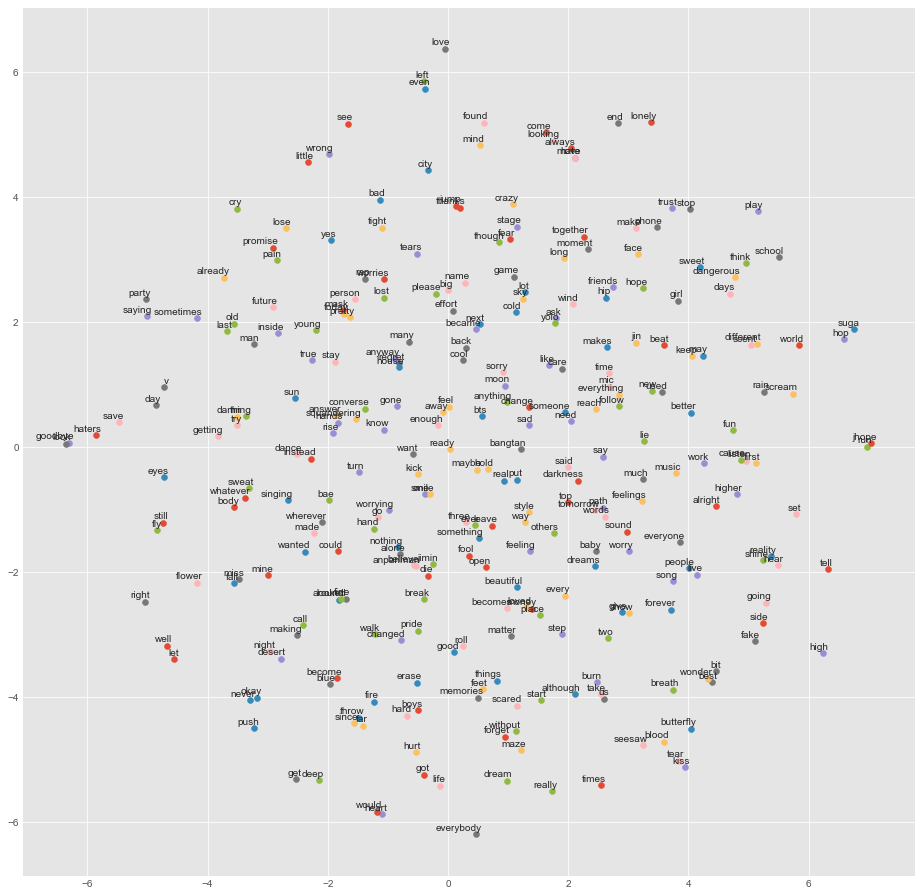

In [40]:
tsne_plot(w2v_model)